In [36]:
# clone git

In [37]:
!rm -rf ../external_git

In [38]:
!git clone https://github.com/OnlpLab/Hebrew-Sentiment-Data.git ../external_git/OnlpLab
!git clone https://github.com/wzwzeyal/nlp_utils_repo.git ../external_git/nlp_utils_repo

Cloning into '../external_git/OnlpLab'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 67 (delta 35), reused 27 (delta 15), pack-reused 0
Unpacking objects: 100% (67/67), 1.65 MiB | 87.00 KiB/s, done.
Cloning into '../external_git/nlp_utils_repo'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 25 (delta 10), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (25/25), 3.63 KiB | 619.00 KiB/s, done.


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from externalGit.nlp_utils_repo.nlp_utils import clean_data


In [40]:
ROOT_PATH = '../external_git/OnlpLab/Sentiment_Data'
FIG_SIZE = (20, 15)


In [41]:
def get_onlp_data(token_or_morph, data_type):
  return pd.read_csv(f'{ROOT_PATH}/{token_or_morph}/{data_type}.tsv', sep='\t')

In [64]:
train_token_df = get_onlp_data('token', 'train')
val_token_df = get_onlp_data('token', 'dev')

train_morph_df = get_onlp_data('morph', 'train')
val_morph_df = get_onlp_data('morph', 'dev')

In [65]:
datasets = [
  {"name": "train_token_df", "df": train_token_df},
  {"name": "val_token_df", "df": val_token_df},
  {"name": "train_morph_df", "df": train_morph_df},
  {"name": "val_morph_df", "df": val_morph_df},
]

In [66]:
codes = {0 : 'pos', 1: 'neg', 2: 'nut'}
palette = {'pos': 'green', 'neg': 'red', 'nut': 'gray'}


In [67]:
for dataset in datasets:
  df = dataset['df']
  clean_data(df, 'comment', 'comment_clean')
  df = df.label.map(codes)
  df = df.comment_clean.str.len()

AttributeError: 'Series' object has no attribute 'comment_clean'

In [45]:
train_token_df.sample(5)

,comment,label,comment_clean,sentiment,comment_clean_len
2317,זה בכלל לא הסתה זה עניין כבר של התבוללות ואוי ...,1,זה בכלל לא הסתה זה עניין כבר של התבוללות ואוי ...,neg,115
2896,אנשים כמוך כבר בפח של ההיסתוריה !! העתיד ליהוד...,1,אנשים כמוך כבר בפח של ההיסתוריה העתיד ליהודים ...,neg,85
3466,חבל שאתה לא מגנה את ערביי ישראל שקוראים להשמדת...,1,חבל שאתה לא מגנה את ערביי ישראל שקוראים להשמדת...,neg,179
1430,בשביל סטטוסים כאלה שווה לשמור על מוסד הנשיאות ...,0,בשביל סטטוסים כאלה שווה לשמור על מוסד הנשיאות ...,pos,96
1054,הלב נקרע .,0,הלב נקרע,pos,8


In [46]:
val_token_df.sample(5)

,comment,label,comment_clean,sentiment,comment_clean_len
725,שלום !! אייך אני כותבת לך מכתב אישי ??,0,שלום אייך אני כותבת לך מכתב אישי,pos,32
792,מספר 1 !,0,מספר,pos,4
611,רובי מזל טוב . זה ממש קל עכשיו ... תדבר מהלב ...,0,רובי מזל טוב זה ממש קל עכשיו תדבר מהלב אל תאנו...,pos,139
20,ומה עם ביטחון שמעתה על זה הנשיא מדינת בלוף,1,ומה עם ביטחון שמעתה על זה הנשיא מדינת בלוף,neg,42
654,הבנתי ... אז בשם הדמוקרטיה המזורגגת שקוברת את ...,1,הבנתי אז בשם הדמוקרטיה המזורגגת שקוברת את כולנ...,neg,443


In [47]:
train_morph_df.sample(5)

,comment,label,comment_clean,sentiment,comment_clean_len
2221,מזל טוב ו חיים ארוכים ו טובים 🌹,0,מזל טוב חיים ארוכים טובים,pos,25
788,התברכת ב נכדה מקסימה . מאחלת ל אתה הצלחה ב כל ...,0,התברכת נכדה מקסימה מאחלת אתה הצלחה כל מעשי ידך...,pos,54
1775,"מצטרפת ל כל מילה כתובה על ידך , ארז כספי .",0,מצטרפת כל מילה כתובה על ידך ארז כספי,pos,36
3212,יהי זכרו ב ה רוך . מנוחתו עדן .,0,יהי זכרו רוך מנוחתו עדן,pos,23
5609,מה לעשות ש אנחנו אוהבים יהודים ..,1,מה לעשות אנחנו אוהבים יהודים,neg,28


In [48]:
val_morph_df.sample(5)

,comment,label,comment_clean,sentiment,comment_clean_len
621,נשיע מדינת ישראל אני קצת מהורהר בגלל מה ש כתב...,1,נשיע מדינת ישראל אני קצת מהורהר בגלל מה כתבת י...,neg,606
182,עצוב עצוב עצוב,0,עצוב עצוב עצוב,pos,14
237,מזל טוב 😊,0,מזל טוב,pos,7
154,מלאך קטן . ש לא נדע . כמה עצוב .,0,מלאך קטן לא נדע כמה עצוב,pos,24
17,ש בת שלום ו מבורך ל רובי ריבלין .,0,בת שלום מבורך רובי ריבלין,pos,25


In [49]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

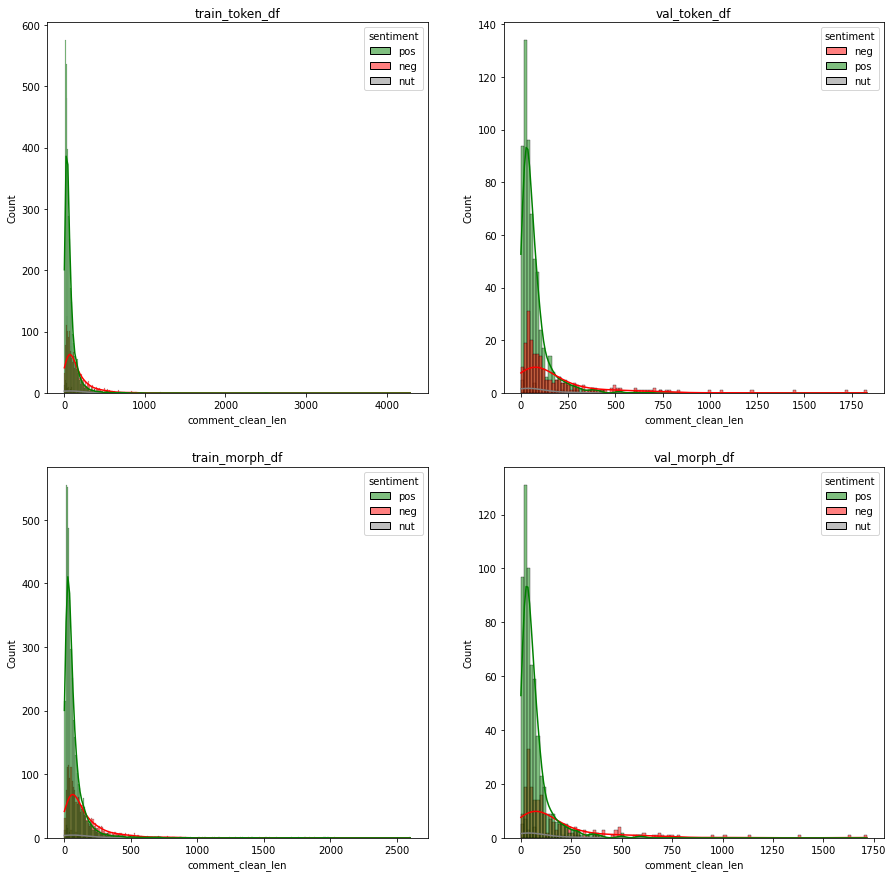

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))#, gridspec_kw={'hspace': 1.2, 'wspace': 1.5})

for ax, dataset in zip(axes.flatten(), datasets):
  sns.histplot(dataset, x='comment_clean_len', hue='sentiment', palette=palette, ax=ax, kde=True)
  ax.set_title(retrieve_name(dataset)[0])

plt.show()


#for ax in axs:


In [51]:
MAX_LEN=512

for idx in range(len(datasets)):
  datasets[idx] = datasets[idx][datasets[idx].comment_clean_len < MAX_LEN]

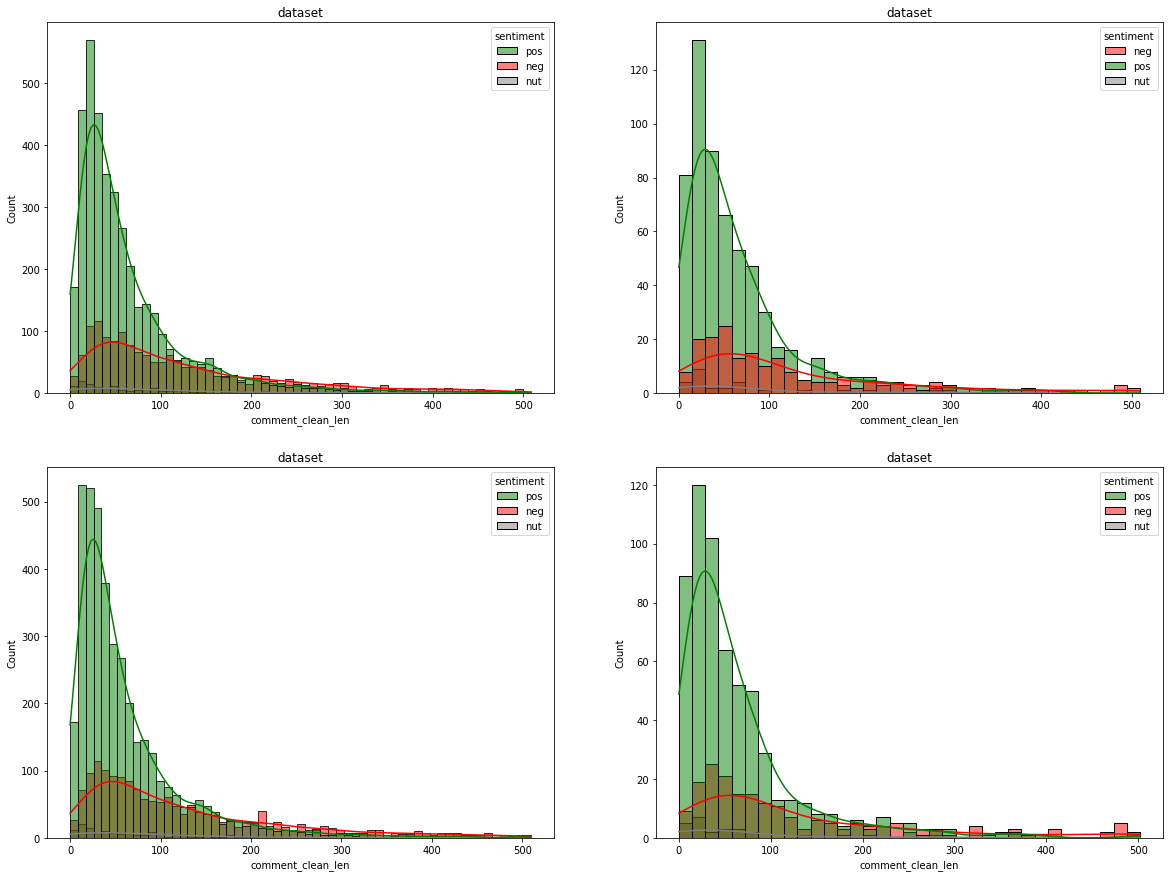

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=FIG_SIZE)

for ax, dataset in zip(axes.flatten(), datasets):
  sns.histplot(dataset, x='comment_clean_len', hue='sentiment', palette=palette, ax=ax, kde=True)
  ax.set_title(retrieve_name(dataset)[0])

plt.show()

In [57]:
SENTIMENT_DATA = '../data/for_sentiment'

!mkdir SENTIMENT_DATA

for dataset in datasets:
  name = retrieve_name(dataset)
  print(name)
  dataset.to_csv(
      f'{SENTIMENT_DATA}/{name}.gz',
       compression = 'gzip')

mkdir: cannot create directory ‘SENTIMENT_DATA’: File exists
['dataset']
['dataset']
['dataset']
['dataset']
